In [30]:
from casadi import *
from casadi.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# Keller's model

> In his original 1974 paper, Keller proposed a model to determine "how a runner should vary his speed $v(t)$ during a race of distance $D$ in order to run it in the shortest time". 

$$D = \int_0^T v(t) dt$$

> The velocity satisfies the equation of motion:

$$\frac{dv}{dt} + \frac{v}{\tau} = f(t)$$

> $v/\tau$ is a resistive force per unit mass, $\tau$ is a given constant, $f(t)$ is the propulsive force per unit mass, controlled by the runner. Furthermore, $\forall t \ f(t)\leq F$, where $F$ is a maximum value.  

> The force affects the quantity $E(t)$ of available oxygen in the muscles per unit mass (oxygen is consumed in reactions which release the energy used in running). Energy is used at the rate $f v$, the oxygen is supplied at a rate $\sigma$. The oxygen balance equation is:

$$\frac{d E}{d t} = \sigma - f v$$

> Eventually, Keller found $v(t)$, $f(t)$ and $E(t)$ that minimized the total running time $T$. 

> Let's use this model in our optimization problem of the rat running on a treadmill. Let's work entirely in the frame of the laboratory. 

> Taking $f$ as the control parameter, the state can be written as:

$$x = \begin{pmatrix}
x_0(t)\\
x_1(t)
\end{pmatrix}=
\begin{pmatrix}
\textrm{position}\\
\textrm{velocity}
\end{pmatrix}$$

$$\dot{x} = \begin{pmatrix}
x_1(t)\\
u - \frac{(x_1(t)-v_t)}{\tau}
\end{pmatrix}=
\begin{pmatrix}
\textrm{velocity}\\
\textrm{acceleration}
\end{pmatrix}$$

> The cost that we will minimize is:

$$E(x(t),u(t))=\int_0^T \frac{d E}{d t}=\int_0^T \left[\sigma - u\left(x_1(t) - v_t\right)\right] dt$$

> We know (from paper ***) that $v_{max}=\tau \times F$, so the only unknown parameters are $\tau$ and $\sigma$. These can be estimated using values computed for human beings. The influence of these parameters on the optimal trajectories is discussed in the following sections.

$$0.0 \leq x_0(t) \leq L_{tread}$$
$$-0.6 \leq x_1(t) \leq 0.1$$ 

The rat should only run against the treadmill with an absolute velocity $|v_{max}|=0.7$ m/s.

$$-\frac{|v_{max}|}{\tau} \leq f(t) \leq \frac{|v_{max}|}{\tau}$$

In [139]:
def penalty_function(x,t,mux,mut,kxpenalty,steepnesst,vtapis):
    '''This function generates a spatio-temporal energy barrier: spatially centered around x = 'mux', with steepness 'kxpenalty'
    and temporally centered around t = 'mut', with steepness 'steepnesst'.'''
    kTt = mut/steepnesst
    max_height=.4                   # cost of running 10s at the velocity of the treadmill (max penalty)
    amplitude = max_height/(1+np.exp((t-mut)/kTt))  # penalty maximum at t=mut...
    kTx = mux/kxpenalty
    return(10*amplitude/(1+np.exp((x-mux)/kTx)))       # ...and x=mux

# def reward_function(x,t,mux,mut,steepnesst):
#     '''This function generates a spatio-temporal energy valley: spatially centered around x = mux (gaussian
#     with variance sigma2), and starting temporally at t = mut with a slope determined by steepnesst'''
#     sigma1 = 3.0        #temporal variance (of associated gaussian)
#     kT = mut/steepnesst
#     amplitude = -np.exp(-(t-mut)**2/2/sigma1**2)/(1+np.exp((-(t-mut))/kT))  #asymmetric time evolution (x=0)
#     sigma2=0.01
#     return(10*amplitude*np.exp(-(x-mux)**2/2/sigma2**2))                   #spatio-temporal evolution


def heaviside(x,k,mu,amp):
    return(amp/(1+np.exp(-2*k*(x-mu))))

def reward_function2(t,dt,reward_max,x,sigma_x,mu_x):
    mu=7.0 #the reward peak is centered around this value
    coeff_rwd_decrease = (-0.38*reward_max+reward_max)/(15.0-mu) #experimental coefficient for the linear decrease of the reward
    amplitude = heaviside(x=t,k=1000,mu=mu+dt,amp=reward_max/dt+coeff_rwd_decrease)+heaviside(x=t,k=1000,mu=mu-dt,amp=-reward_max/dt)
    return(amplitude*np.exp(-(x-mu_x)**2/2/sigma_x**2))   


def optimal_trajectory(tau_res,sigma,x0,xf,tf,vtapis,kxpenalty):
    '''This function takes parameters a, b, initial position x0 and final position xf and 
    computes the OC problem assuming either a linear cost (cost='linear', Int_0^T a+b*v dt), 
    or a quadratic one (cost='quadratic',Int_0^T a+b*v*v dt). It returns respectively the 
    optimal trajectory, the associated time array, the optimal 
    velocity and its associated time array.'''
    Ltread=0.9
    nk = 5000
    mu=0.1    # Control discretization
    kT=mu/1
    
    
    # Declare variables
    t  = SX.sym("t")    # time
    u  = SX.sym("u")    # control

    states = struct_symSX([
            entry('x',shape=2),    #  states
            entry('L')             #  helper state: Langrange integrand
         ])

    # Create a structure for the right hand side
    rhs = struct_SX(states)
    x = states['x']
    rhs["x"] = vertcat(x[1], u -(x[1]-vtapis)/tau_res)
    rhs["L"] = sigma - u*(x[1]-vtapis)+reward_function2(t=t,dt=1,reward_max=10.0,x=x[0],sigma_x=0.01,mu_x=0.1)#+penalty_function(x=x[0],t=t,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)+reward_function(x=x[0],t=t,mux=0.1,mut=6.95,steepnesst=1000)
    
    # ODE right hand side function
    f = Function('f', [t,states,u],[rhs])

    # Objective function (meyer term)
    m = Function('m', [t,states,u],[states["L"]])

    # Control bounds
    u_min = -0.7/tau_res
    u_max = -u_min
    u_init = 0.0

    u_lb = np.array([u_min])
    u_ub = np.array([u_max])
    u_init = np.array([u_init])

    # State bounds and initial guess
    x_min =  [0.0,   vtapis-0.7, -inf]
    x_max =  [Ltread,vtapis,  inf]
    xi_min = [x0,  vtapis-0.7,  0.0]
    xi_max = [x0,  vtapis,  0.0]
    xf_min = [xf,  vtapis-0.7, -inf]
    xf_max = [xf,  vtapis,  inf]
    x_init = [ 0.0,  0.0,  0.0]

    # Dimensions
    nx = 3
    nu = 1

    # Choose collocation points
    tau_root = [0] + collocation_points(3,"radau")

    # Degree of interpolating polynomial
    d = len(tau_root)-1

    # Size of the finite elements
    h = tf/nk

    # Coefficients of the collocation equation
    C = np.zeros((d+1,d+1))

    # Coefficients of the continuity equation
    D = np.zeros(d+1)

    # Dimensionless time inside one control interval
    tau = SX.sym("tau")

    # All collocation time points
    T = np.zeros((nk,d+1))
    for k in range(nk):
        for j in range(d+1):
            T[k,j] = h*(k + tau_root[j])

    # For all collocation points
    for j in range(d+1):
    # Construct Lagrange polynomials to get the polynomial basis at the collocation point
        L = 1
        for r in range(d+1):
            if r != j:
                L *= (tau-tau_root[r])/(tau_root[j]-tau_root[r])

        # Evaluate the polynomial at the final time to get the coefficients of the continuity equation
        lfcn = Function('lfcn', [tau],[L])
        D[j] = lfcn(1.0)

        # Evaluate the time derivative of the polynomial at all collocation points to get the coefficients of the continuity equation
        tfcn = Function('tfcn', [tau],[tangent(L,tau)])
        for r in range(d+1):
            C[j,r] = tfcn(tau_root[r])

    # Structure holding NLP variables
    V = struct_symMX([
      (
       entry("X",repeat=[nk+1,d+1],struct=states),
       entry("U",repeat=[nk],shape=nu)
      )
    ])

    vars_lb   = V()
    vars_ub   = V()
    vars_init = V()

    # Set states and its bounds
    vars_init["X",:,:] = repeated(repeated(x_init))
    vars_lb["X",:,:]   = repeated(repeated(x_min))
    vars_ub["X",:,:]   = repeated(repeated(x_max))

    # Set controls and its bounds
    vars_init["U",:] = repeated(u_init)
    vars_lb["U",:]   = repeated(u_min)
    vars_ub["U",:]   = repeated(u_max)

    # State at initial time
    vars_lb["X",0,0] = xi_min
    vars_ub["X",0,0] = xi_max

    # State at end time
    vars_lb["X",-1,0] = xf_min
    vars_ub["X",-1,0] = xf_max

    # Constraint function for the NLP
    g = []
    lbg = []
    ubg = []

    # For all finite elements
    for k in range(nk):

        # For all collocation points
        for j in range(1,d+1):

        # Get an expression for the state derivative at the collocation point
            xp_jk = 0
            for r in range (d+1):
                xp_jk += C[r,j]*V["X",k,r]

            # Add collocation equations to the NLP
            fk = f(T[k][j], V["X",k,j], V["U",k])
            g.append(h*fk - xp_jk)
            lbg.append(np.zeros(nx)) # equality constraints
            ubg.append(np.zeros(nx)) # equality constraints

        # Get an expression for the state at the end of the finite element
        xf_k = 0
        for r in range(d+1):
            xf_k += D[r]*V["X",k,r]

        # Add continuity equation to NLP
        g.append(V["X",k+1,0] - xf_k)
        lbg.append(np.zeros(nx))
        ubg.append(np.zeros(nx))

    # Concatenate constraints
    g = vertcat(*g)

    # Objective function
    f = m(T[nk-1][d],V["X",nk,0],V["U",nk-1])

    # NLP
    nlp = {'x':V, 'f':f, 'g':g}

    ## ----
    ## SOLVE THE NLP
    ## ----

    # Set options
    opts = {}
    opts["expand"] = True
    #opts["ipopt.max_iter"] = 4

    # Allocate an NLP solver
    solver = nlpsol("solver", "ipopt", nlp, opts)
    arg = {}

    # Initial condition
    arg["x0"] = vars_init

    # Bounds on x
    arg["lbx"] = vars_lb
    arg["ubx"] = vars_ub

    # Bounds on g
    arg["lbg"] = np.concatenate(lbg)
    arg["ubg"] = np.concatenate(ubg)

    # Solve the problem
    res = solver(**arg)

    # Print the optimal cost
    print("optimal cost: ", float(res["f"]))

    # Retrieve the solution
    opt = V(res["x"])

    # Get values at the beginning of each finite element
    x0_opt = opt["X",:,0,"x",0]
    x1_opt = opt["X",:,0,"x",1]
    x2_opt = opt["X",:,0,"L"]

    u_opt = opt["U",:,0]

    tgrid = np.linspace(0,tf,nk+1)
    tgrid_u = np.linspace(0,tf,nk)
    
    return(x0_opt,x1_opt,tgrid,u_opt,tgrid_u)


In [140]:
# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 15.     # final time (duration of experiment)

sigma = 1.708
tau = 0.1
xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=tau,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   279348
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24355

Total number of variables............................:    65009
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    45006
                     variables with only upper bounds:        0
Total number of equality constraints.................:    60000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  81 1.6592662e+001 5.65e-005 7.16e-002  -5.7 9.57e-001  -3.3 1.00e+000 2.80e-001h  1
  82 1.6570192e+001 6.11e-005 1.00e-001  -5.7 3.09e+000  -3.8 6.28e-001 1.58e-001h  1
  83 1.6556696e+001 5.19e-005 8.23e-002  -5.7 1.05e+000  -3.4 1.00e+000 2.27e-001h  1
  84 1.6536387e+001 7.08e-005 7.37e-002  -5.7 3.41e+000  -3.9 6.18e-001 1.52e-001h  1
  85 1.6525776e+001 6.12e-005 8.46e-002  -5.7 1.14e+000  -3.4 1.00e+000 1.94e-001h  1
  86 1.6502062e+001 9.83e-005 5.99e-002  -5.7 3.81e+000  -3.9 6.10e-001 1.83e-001h  1
  87 1.6492291e+001 8.43e-005 6.27e-002  -5.7 1.24e+000  -3.5 1.00e+000 1.90e-001h  1
  88 1.6470298e+001 1.22e-004 4.44e-002  -5.7 4.34e+000  -4.0 8.32e-001 1.74e-001h  1
  89 1.6457033e+001 9.88e-005 3.24e-002  -5.7 1.32e+000  -3.5 1.00e+000 2.81e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.6447690e+001 9.86e-005 4.71e-002  -5.7 4.51e+000  -4.0 5.35e-001 9.46e-002h  1
  91 1.6439958e+001 8.12e-005 4.50e-002  -5.7 1.40e+000  -3

 169 1.6365183e+001 7.91e-005 3.79e-001  -5.7 3.95e+000  -4.7 2.75e-001 4.29e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.6365090e+001 8.48e-005 3.74e-001  -5.7 5.70e+001  -5.2 1.30e-002 1.41e-002f  1
 171 1.6365067e+001 7.63e-005 3.32e-001  -5.7 3.95e+000  -5.6 7.33e-002 1.13e-001f  1
 172 1.6365102e+001 4.11e-005 2.99e-001  -5.7 5.35e+000  -5.2 9.96e-002 4.01e-001f  1
 173 1.6364987e+001 4.00e-005 3.60e-001  -5.7 5.63e+000  -4.8 4.18e-001 2.02e-001f  1
 174 1.6364811e+001 1.98e-005 2.38e-001  -5.7 1.33e+000  -4.4 7.20e-001 1.00e+000f  1
 175 1.6364574e+001 7.87e-005 1.47e-001  -5.7 8.62e+000  -4.8 1.57e-001 2.88e-001h  1
 176 1.6364633e+001 5.45e-005 2.45e-001  -5.7 1.88e+000  -4.4 4.80e-001 3.09e-001f  2
 177 1.6364587e+001 4.59e-005 2.47e-001  -5.7 4.21e+000  -4.9 9.38e-002 1.73e-001h  1
 178 1.6364472e+001 1.64e-005 5.11e-005  -5.7 1.48e+000  -4.5 1.00e+000 1.00e+000f  1
 179 1.6364283e+001 5.76e-005 6.59e-002  -5.7 1.16e+001  -4

 259 1.6356226e+001 8.78e-006 6.62e-001  -5.7 1.17e+000  -4.3 5.78e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.6356093e+001 6.63e-005 2.62e-001  -5.7 3.69e+000  -4.8 2.99e-001 6.59e-001h  1
 261 1.6356033e+001 6.27e-005 2.42e-001  -5.7 2.22e+001  -5.2 4.86e-002 7.28e-002f  1
 262 1.6355984e+001 5.49e-005 2.90e+000  -5.7 3.75e+000  -4.8 4.99e-002 2.18e-001f  1
 263 1.6355821e+001 2.78e-005 5.62e-002  -5.7 1.72e+000  -4.4 6.26e-001 9.02e-001f  1
 264 1.6355736e+001 3.77e-005 3.05e-001  -5.7 3.93e+000  -4.9 8.81e-002 4.72e-001f  1
 265 1.6355610e+001 3.23e-005 6.85e-001  -5.7 2.17e+000  -4.4 8.18e-002 3.27e-001f  1
 266 1.6355581e+001 4.74e-005 4.02e-001  -5.7 5.84e+000  -4.9 2.08e-001 3.83e-001f  1
 267 1.6355311e+001 3.13e-005 1.76e-001  -5.7 2.52e+000  -4.5 6.48e-001 6.04e-001f  1
 268 1.6355195e+001 3.25e-005 3.51e-001  -5.7 3.71e+001  -5.0 3.69e-002 1.75e-002h  1
 269 1.6354902e+001 4.03e-005 5.07e-001  -5.7 3.03e+000  -4

 348 1.6346537e+001 3.19e-005 8.90e+000  -5.7 1.44e+000  -4.3 7.47e-001 2.96e-001h  1
 349 1.6346258e+001 6.17e-005 6.65e+000  -5.7 8.50e+000  -4.8 6.08e-002 2.16e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350 1.6346152e+001 4.96e-005 4.70e+000  -5.7 1.86e+000  -4.3 9.03e-002 2.46e-001f  1
 351 1.6346073e+001 4.13e-005 4.20e+000  -5.7 7.09e+000  -4.8 2.60e-001 1.42e-001f  1
 352 1.6345958e+001 1.09e-005 9.82e-001  -5.7 1.46e+000  -4.4 1.00e+000 7.72e-001f  1
 353 1.6345674e+001 4.76e-005 7.57e-001  -5.7 8.42e+000  -4.9 1.10e-001 2.28e-001f  1
 354 1.6345232e+001 4.63e-005 2.96e+000  -5.7 2.02e+000  -4.4 1.84e-001 9.13e-001f  1
 355 1.6344998e+001 6.55e-005 1.99e+000  -5.7 7.94e+000  -4.9 1.91e-001 3.24e-001f  1
 356 1.6344978e+001 3.91e-005 8.02e-001  -5.7 2.38e+000  -4.5 5.12e-001 1.00e+000f  1
 357 1.6344743e+001 6.01e-005 6.72e-001  -5.7 2.41e+001  -5.0 8.96e-002 1.03e-001h  1
 358 1.6344741e+001 6.00e-005 6.76e-001  -5.7 2.51e+001  -5

 437 1.6335786e+001 1.57e-005 7.49e-001  -5.7 1.82e+000  -4.3 1.60e-001 2.77e-001f  1
 438 1.6335653e+001 2.91e-005 7.55e-001  -5.7 4.23e+000  -4.8 2.10e-001 3.96e-001f  1
 439 1.6335466e+001 2.08e-005 1.17e+000  -5.7 1.73e+000  -4.4 2.10e-001 4.41e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440 1.6335220e+001 3.75e-005 1.04e+000  -5.7 1.30e+001  -4.8 8.88e-002 9.51e-002f  1
 441 1.6335144e+001 3.13e-005 6.04e-001  -5.7 1.80e+000  -4.4 1.34e-001 2.19e-001f  1
 442 1.6334856e+001 7.07e-005 3.33e-001  -5.7 1.83e+001  -4.9 9.11e-002 1.34e-001f  1
 443 1.6334879e+001 6.35e-005 2.89e+000  -5.7 2.33e+000  -5.4 2.34e-002 9.95e-002f  1
 444 1.6334652e+001 1.01e-004 2.76e+000  -5.7 1.05e+001  -4.9 9.10e-002 2.93e-001f  1
 445 1.6334684e+001 9.67e-005 2.87e+000  -5.7 3.72e+000  -5.4 5.08e-002 4.21e-002f  4
 446 1.6334525e+001 1.02e-004 2.79e+000  -5.7 3.37e+001  -5.0 2.99e-002 3.08e-002h  1
 447 1.6334521e+001 7.45e-005 2.01e+000  -5.7 2.29e+000  -5

 526 1.6325284e+001 2.91e-005 8.80e-001  -5.7 2.05e+000  -4.3 2.58e-001 5.02e-001f  1
 527 1.6325107e+001 3.69e-005 8.13e-001  -5.7 1.28e+001  -4.8 1.15e-001 1.01e-001f  1
 528 1.6324979e+001 4.15e-005 4.10e+000  -5.7 1.67e+001  -5.3 1.41e-002 6.33e-002f  1
 529 1.6324808e+001 4.15e-005 3.71e+000  -5.7 1.35e+001  -4.9 7.23e-002 8.52e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 530 1.6324790e+001 4.00e-005 3.40e+000  -5.7 5.50e+000  -5.3 5.53e-002 5.89e-002f  1
 531 1.6324489e+001 6.90e-005 3.35e+000  -5.7 3.91e+001  -4.9 8.44e-004 4.76e-002f  1
 532 1.6324530e+001 5.36e-005 5.42e+000  -5.7 2.89e+000  -4.5 1.12e-001 4.93e-001f  2
 533 1.6324404e+001 3.51e-005 3.75e+000  -5.7 1.01e+000  -4.1 1.00e+000 3.69e-001h  1
 534 1.6324189e+001 3.11e-005 2.86e+000  -5.7 3.76e+000  -4.5 3.01e-001 2.00e-001f  1
 535 1.6324094e+001 1.03e-005 3.81e-001  -5.7 9.13e-001  -4.1 1.00e+000 8.70e-001f  1
 536 1.6323916e+001 2.54e-005 2.46e-001  -5.7 3.59e+000  -4

 615 1.6312533e+001 4.11e-005 5.92e+000  -5.7 2.22e+000  -4.4 7.82e-002 5.70e-001f  1
 616 1.6312513e+001 4.06e-005 5.86e+000  -5.7 8.14e+000  -4.8 5.40e-002 1.22e-002f  1
 617 1.6312301e+001 2.66e-005 3.10e+000  -5.7 2.66e+000  -4.4 4.42e-001 4.69e-001f  1
 618 1.6312290e+001 2.61e-005 3.01e+000  -5.7 7.14e+000  -4.9 7.05e-002 2.50e-002f  1
 619 1.6311992e+001 4.83e-005 1.29e+000  -5.7 2.83e+000  -4.5 3.81e-001 8.04e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620 1.6311883e+001 5.11e-005 1.29e+000  -5.7 9.27e+001  -4.9 5.86e-003 6.11e-003f  1
 621 1.6311885e+001 4.87e-005 1.61e+000  -5.7 6.62e+000  -5.4 2.93e-002 6.42e-002f  1
 622 1.6311734e+001 5.49e-005 1.83e+000  -5.7 9.33e+001  -5.0 1.64e-004 9.25e-003f  1
 623 1.6311651e+001 4.53e-005 1.41e+000  -5.7 4.32e+000  -4.6 3.00e-001 2.52e-001f  1
 624 1.6311607e+001 4.30e-005 1.32e+000  -5.7 1.11e+001  -5.0 4.92e-002 5.16e-002f  1
 625 1.6311612e+001 5.61e-005 1.03e+001  -5.7 8.50e+000  -5

 702 1.6300436e+001 3.35e-005 6.80e+000  -5.7 2.29e+000  -4.3 4.36e-001 1.13e-001f  1
 703 1.6300206e+001 4.10e-005 6.55e+000  -5.7 2.48e+001  -4.8 3.17e-002 3.82e-002f  1
 704 1.6300083e+001 5.33e-005 1.95e+001  -5.7 1.83e+001  -5.3 2.04e-003 7.35e-002f  1
 705 1.6300071e+001 4.93e-005 1.83e+001  -5.7 9.72e+000  -5.8 5.14e-002 6.44e-002f  1
 706 1.6299939e+001 4.58e-005 1.61e+001  -5.7 4.35e+000  -4.4 4.25e-002 1.20e-001f  1
 707 1.6299908e+001 4.13e-005 1.46e+001  -5.7 9.75e-001  -4.0 1.00e+000 1.00e-001f  1
 708 1.6299680e+001 4.17e-005 6.48e+000  -5.7 2.98e+000  -4.5 4.21e-001 5.62e-001f  1
 709 1.6299809e+001 5.55e-005 1.84e+001  -5.7 3.03e+000  -4.9 5.98e-002 8.05e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 710 1.6299674e+001 5.09e-005 1.57e+001  -5.7 4.42e+000  -4.5 2.11e-001 1.44e-001f  1
 711 1.6299544e+001 5.05e-005 1.56e+001  -5.7 1.69e+002  -5.0 2.59e-003 6.71e-003f  1
 712 1.6299183e+001 7.25e-005 9.32e+000  -5.7 3.11e+000  -4

 791 1.6286492e+001 3.10e-005 7.69e-001  -5.7 2.73e+000  -4.3 4.12e-001 9.33e-001f  1
 792 1.6286455e+001 3.09e-005 1.30e+000  -5.7 3.07e+001  -4.8 2.64e-002 3.45e-003f  1
 793 1.6286245e+001 2.39e-005 1.14e+000  -5.7 2.54e+000  -4.4 5.32e-002 2.27e-001f  1
 794 1.6286095e+001 1.04e-005 2.26e-001  -5.7 9.34e-001  -4.0 7.36e-001 7.61e-001f  1
 795 1.6286013e+001 1.05e-005 8.77e-001  -5.7 2.90e+000  -4.4 1.79e-001 8.19e-002f  1
 796 1.6285530e+001 2.10e-005 1.21e+000  -5.7 1.04e+000  -4.0 5.36e-001 1.00e+000f  1
 797 1.6285306e+001 2.47e-005 1.15e+000  -5.7 4.93e+000  -4.5 1.91e-001 1.27e-001h  1
 798 1.6285262e+001 2.52e-005 4.16e+000  -5.7 4.77e+000  -5.0 3.54e-002 1.14e-001f  1
 799 1.6284988e+001 3.34e-005 3.01e+000  -5.7 6.17e+000  -4.5 1.17e-001 2.35e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800 1.6284972e+001 3.34e-005 5.03e+000  -5.7 7.08e+001  -5.0 1.00e-002 1.07e-003f  1
 801 1.6284718e+001 3.40e-005 4.40e+000  -5.7 8.19e+000  -4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880 1.6272850e+001 3.37e-005 6.91e+000  -5.7 3.52e+000  -4.4 1.62e-001 3.90e-001f  1
 881 1.6272745e+001 2.88e-005 7.45e+000  -5.7 9.62e-001  -3.9 7.32e-001 1.61e-001f  1
 882 1.6272565e+001 2.90e-005 6.53e+000  -5.7 3.48e+000  -4.4 2.70e-001 1.55e-001f  1
 883 1.6272274e+001 4.17e-005 5.84e+000  -5.7 1.40e+001  -4.9 2.69e-002 1.07e-001f  1
 884 1.6272253e+001 4.04e-005 6.26e+000  -5.7 2.86e+000  -4.5 1.82e-001 2.96e-002f  1
 885 1.6271797e+001 2.19e-005 6.49e+000  -5.7 1.49e+000  -4.0 2.09e-001 6.92e-001f  1
 886 1.6271477e+001 3.10e-005 4.78e+000  -5.7 5.04e+000  -4.5 1.62e-001 1.97e-001f  1
 887 1.6271536e+001 2.53e-005 1.00e+001  -5.7 3.82e+000  -5.0 4.17e-002 2.12e-001f  1
 888 1.6271022e+001 4.27e-005 9.09e+000  -5.7 9.10e+000  -4.6 5.95e-002 1.29e-001f  1
 889 1.6270957e+001 3.40e-005 6.66e+000  -5.7 2.02e+000  -4.1 8.60e-002 2.19e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 967 1.6258213e+001 3.93e-005 9.56e+000  -5.7 3.98e+000  -4.3 7.67e-002 1.37e-001f  1
 968 1.6257944e+001 1.90e-005 3.73e+000  -5.7 1.20e+000  -3.9 6.37e-001 6.10e-001f  1
 969 1.6257947e+001 1.69e-005 3.28e+000  -5.7 1.60e+000  -4.4 7.53e-002 1.19e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 970 1.6257520e+001 1.98e-005 1.22e+000  -5.7 1.16e+000  -3.9 4.57e-001 6.20e-001f  1
 971 1.6257329e+001 1.74e-005 1.10e+000  -5.7 4.65e+000  -4.4 8.44e-002 9.85e-002f  1
 972 1.6257231e+001 1.54e-005 1.67e+000  -5.7 1.51e+000  -4.0 5.61e-001 1.20e-001f  1
 973 1.6256796e+001 3.75e-005 1.35e+001  -5.7 3.63e+000  -4.5 1.35e-002 4.31e-001f  1
 974 1.6256976e+001 3.08e-005 6.42e+000  -5.7 2.69e+000  -5.0 6.15e-002 1.63e-001f  1
 975 1.6256590e+001 4.03e-005 5.36e+000  -5.7 7.96e+000  -4.5 1.10e-001 1.82e-001f  1
 976 1.6256303e+001 2.52e-005 3.85e+000  -5.7 1.67e+000  -4.1 6.80e-001 3.48e-001f  1
 977 1.6256213e+001 2.51e-005 4.10e+000  -5.7 1.23e+001  -4

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060 1.6243205e+001 6.45e-005 8.94e+000  -5.7 1.18e+001  -4.4 8.91e-003 2.42e-002f  1
1061 1.6243040e+001 5.51e-005 7.61e+000  -5.7 2.10e+000  -4.0 3.69e-001 1.48e-001f  1
1062 1.6242205e+001 5.21e-005 7.07e+000  -5.7 1.76e+001  -4.5 2.58e-002 6.56e-002f  1
1063 1.6242439e+001 7.07e-005 7.90e+000  -5.7 9.01e+000  -5.0 2.66e-002 1.37e-001f  1
1064 1.6241885e+001 6.81e-005 6.94e+000  -5.7 1.65e+001  -4.5 5.20e-002 3.90e-002f  1
1065 1.6241851e+001 6.73e-005 1.12e+001  -5.7 2.76e+000  -4.1 2.73e-001 1.28e-002h  1
1066 1.6241311e+001 6.32e-005 2.86e+001  -5.7 5.71e+000  -3.7 1.01e-002 6.01e-002f  1
1067 1.6240611e+001 4.08e-005 7.16e+000  -5.7 2.59e+000  -4.2 3.88e-002 3.74e-001f  1
1068 1.6240321e+001 2.75e-005 4.67e+000  -5.7 1.32e+000  -3.7 5.05e-001 3.29e-001f  1
1069 1.6240214e+001 2.65e-005 6.93e+000  -5.7 3.63e+000  -4.2 2.93e-001 3.63e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

1148 1.6214699e+001 1.13e-005 4.98e+000  -5.7 1.67e+000  -4.0 3.61e-001 3.17e-001f  1
1149 1.6214336e+001 1.41e-005 3.79e+000  -5.7 8.21e+000  -4.5 3.08e-002 6.68e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1150 1.6214111e+001 1.32e-005 3.30e+000  -5.7 1.88e+000  -4.0 1.66e-001 1.56e-001f  1
1151 1.6214036e+001 1.09e-005 9.45e+000  -5.7 2.14e+000  -4.5 5.90e-002 2.27e-001f  1
1152 1.6213671e+001 1.15e-005 7.24e+000  -5.7 2.50e+000  -4.1 7.22e-002 1.94e-001f  1
1153 1.6213242e+001 1.25e-005 7.14e+000  -5.7 2.49e+001  -4.6 2.28e-002 1.82e-002f  1
1154 1.6213144e+001 1.57e-005 3.79e+000  -5.7 6.02e+000  -5.0 7.16e-002 1.21e-001f  1
1155 1.6212620e+001 1.94e-005 3.71e+000  -5.7 2.87e+001  -4.6 1.32e-003 2.64e-002f  1
1156 1.6212352e+001 1.73e-005 3.04e+000  -5.7 2.94e+000  -4.2 3.56e-001 1.70e-001f  1
1157 1.6212106e+001 1.82e-005 3.00e+000  -5.7 3.16e+001  -4.7 8.95e-003 1.09e-002f  1
1158 1.6212075e+001 1.84e-005 2.86e+000  -5.7 8.03e+000  -5

1239 1.6185525e+001 2.04e-005 3.44e+000  -5.7 9.24e-001  -4.1 5.85e-001 4.56e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240 1.6184724e+001 4.57e-005 2.07e+000  -5.7 4.07e+000  -4.5 2.12e-001 3.98e-001f  1
1241 1.6184245e+001 5.52e-005 2.37e+000  -5.7 1.52e+001  -5.0 2.23e-002 5.54e-002f  1
1242 1.6184023e+001 4.91e-005 2.61e+000  -5.7 4.57e+000  -4.6 3.80e-001 1.56e-001f  1
1243 1.6183344e+001 6.64e-005 1.11e+001  -5.7 4.40e+000  -5.1 3.43e-002 5.60e-001f  1
1244 1.6183266e+001 6.42e-005 1.11e+001  -5.7 4.07e+000  -4.6 4.84e-002 3.56e-002f  1
1245 1.6183020e+001 6.14e-005 1.06e+001  -5.7 1.79e+001  -5.1 4.04e-002 4.07e-002f  1
1246 1.6182836e+001 5.40e-005 9.22e+000  -5.7 4.17e+000  -4.7 3.67e-001 1.21e-001f  1
1247 1.6182136e+001 2.36e-005 4.17e+000  -5.7 1.43e+000  -4.3 2.22e-001 8.72e-001f  1
1248 1.6181733e+001 2.70e-005 1.67e+000  -5.7 3.25e+000  -4.7 2.44e-001 5.00e-001f  1
1249 1.6181269e+001 4.30e-005 2.20e+000  -5.7 5.15e+001  -5

1326 1.6149206e+001 3.23e-005 8.73e+000  -8.6 2.91e+000  -4.9 7.51e-002 7.41e-002h  1
1327 1.6148818e+001 2.97e-005 8.02e+000  -8.6 1.36e+001  -4.5 4.00e-004 8.09e-002f  1
1328 1.6148566e+001 2.65e-005 7.14e+000  -8.6 3.55e+000  -4.1 1.62e-001 1.10e-001f  1
1329 1.6148556e+001 2.52e-005 6.81e+000  -8.6 1.32e+000  -4.6 2.49e-002 4.65e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330 1.6148046e+001 2.20e-005 5.60e+000  -8.6 4.47e+000  -4.1 2.67e-002 1.77e-001f  1
1331 1.6148046e+001 2.20e-005 6.02e+000  -8.6 2.16e+000  -4.6 5.84e-002 5.14e-005h  1
1332 1.6147193e+001 3.18e-005 4.71e+000  -8.6 5.60e+000  -4.2 7.60e-003 2.31e-001f  1
1333 1.6147193e+001 3.18e-005 6.10e+000  -8.6 2.81e+000  -4.7 7.79e-002 1.25e-004h  1
1334 1.6146693e+001 3.49e-005 7.30e+000  -8.6 9.03e+000  -4.2 1.56e-003 7.89e-002f  1
1335 1.6146508e+001 3.18e-005 6.72e+000  -8.6 1.89e+000  -3.8 2.21e-001 1.01e-001f  1
1336 1.6146500e+001 3.17e-005 6.57e+000  -8.6 7.61e+000  -4

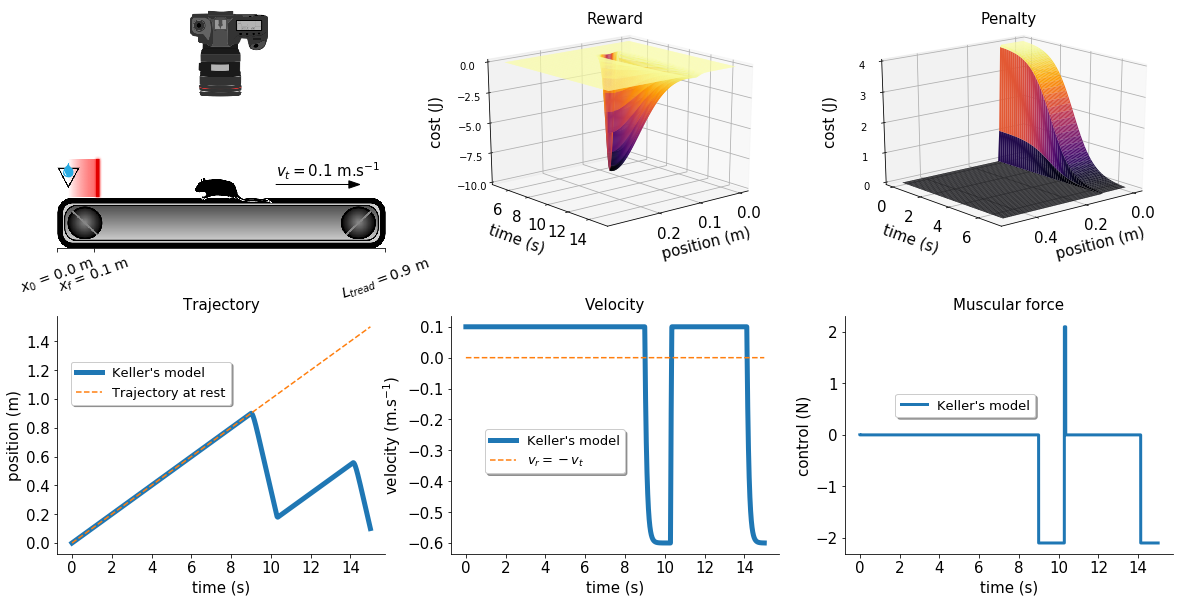

In [141]:
#GENERATE FIGURE
fig3 = plt.figure(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=2)
gs = fig3.add_gridspec(6, 6)

# SCHEME OF THE TASK
f3_ax1 = fig3.add_subplot(gs[:3, :2])
img1 = mpimg.imread('experimental_setup.png')
f3_ax1.imshow(img1,aspect='auto')
f3_ax1.spines['top'].set_visible(False)
f3_ax1.spines['right'].set_visible(False) 
f3_ax1.spines['left'].set_visible(False) 
f3_ax1.set_yticks([])
f3_ax1.set_xticks([x0*1000,xf*1000,900])
plt.xticks(rotation=20)
f3_ax1.set_xticklabels([r'$x_0$ = '+str(x0)+' m',r'$x_f$ = '+str(xf)+' m',r'$L_{tread} = 0.9$ m'],size=14)
plt.arrow(600,470,200,0,head_width=20.0,color='black')
plt.text(600,450,r'$v_t = $'+str(vtapis)+' m.s$^{-1}$',size=15)

#REWARD FUNCTION
f3_ax2 = fig3.add_subplot(gs[:3, 2:4],projection="3d")
f3_ax2.set_title('Reward',size=15)
t = np.linspace(5,15,100)
x = np.linspace(0.0,0.30,100)
X,T = np.meshgrid(x,t)
Z = reward_function(X,T,mux=0.1,mut=6.95,steepnesst=1000)
f3_ax2.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.3, step=0.1))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax2.zaxis.set_rotate_label(False) 
f3_ax2.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax2.set_zticks(np.linspace(0,-10.0,5))
f3_ax2.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#PENALTY FUNCTION
f3_ax3 = fig3.add_subplot(gs[:3, 4:],projection='3d')
f3_ax3.set_title('Penalty',size=15)
x = np.linspace(0.0,0.5,100)
t = np.linspace(0.0,7.0)
X,T = np.meshgrid(x,t)
Z = penalty_function(X,T,mux=0.1,mut=3.5,kxpenalty=kxpenalty,steepnesst=5,vtapis=vtapis)
f3_ax3.plot_surface(X, T, Z, rstride=1, cstride=1,cmap='inferno', edgecolor='none')
plt.xlabel('position (m)',size=15,labelpad=10)
plt.xticks(np.arange(0, 0.5, step=0.2))
plt.yticks(np.arange(0, 7, step=2))
plt.ylabel('time (s)',size=15,labelpad=10)
f3_ax3.zaxis.set_rotate_label(False) 
f3_ax3.set_zlabel('cost (J)',size=15,labelpad=10,rotation=90)
f3_ax3.set_zticks(np.linspace(0,4,5))
f3_ax3.view_init(20, 50)
plt.xticks(size = 15)
plt.yticks(size = 15)


#TRAJECTORY
f3_ax4 = fig3.add_subplot(gs[3:,:2])
f3_ax4.set_title('Trajectory',size=15)
plt.plot(tk,xk,label="Keller's model",linewidth=5.0,alpha=1.0)
plt.plot(tk,[0.1*t for t in tk],'--',label='Trajectory at rest')
f3_ax4.spines['top'].set_visible(False)
f3_ax4.spines['right'].set_visible(False) 
f3_ax4.legend(fontsize=13,bbox_to_anchor=(.55, .6),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.ylabel('position (m)',size=15)
plt.xlabel('time (s)',size=15)


#VELOCITY
f3_ax5 = fig3.add_subplot(gs[3:, 2:4])
f3_ax5.set_title('Velocity',size=15)
plt.plot(tk,xdotk,label="Keller's model",linewidth=5.0)
plt.plot(tk,[0.0 for t in tk],'--',label=r'$v_r=-v_t$')
plt.ylabel(r'velocity (m.s$^{-1}$)',size=15)
plt.xlabel('time (s)',size = 15)
f3_ax5.spines['top'].set_visible(False)
f3_ax5.spines['right'].set_visible(False) 
f3_ax5.legend(fontsize=13,bbox_to_anchor=(.55, .55),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


#Muscular force
f3_ax6 = fig3.add_subplot(gs[3:, 4:])
f3_ax6.set_title('Muscular force',size=15)
plt.step(tak,[0.3*f for f in acck],label="Keller's model",linewidth=3.0)
plt.ylabel(r'control (N)',size=15)
plt.xlabel('time (s)',size=15)
f3_ax6.spines['top'].set_visible(False)
f3_ax6.spines['right'].set_visible(False) 
f3_ax6.legend(fontsize=13,bbox_to_anchor=(.6, .7),shadow=True, ncol=1)
plt.xticks(size = 15)
plt.yticks(size = 15)


plt.savefig('Results_tau'+str(tau)+'sigma_'+str(sigma)+'.pdf')
plt.show()

# Testing $\tau$'s influence

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    28493
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     6509
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4506
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    28493
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3000

Total number of variables............................:     6509
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4506
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6000
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  11 1.5705575e+001 2.61e-005 1.51e-002  -2.5 2.93e-001  -5.2 1.00e+000 1.00e+000h  1
  12 1.5417110e+001 5.36e-002 2.00e+001  -3.8 7.56e-001  -5.6 5.37e-001 1.00e+000f  1
  13 1.5306928e+001 1.68e-002 8.93e+000  -3.8 3.85e-001  -6.1 8.55e-001 1.00e+000h  1
  14 1.5265991e+001 1.48e-002 7.88e+000  -3.8 8.37e+000  -6.6 1.48e-001 1.17e-001h  1
  15 1.5205312e+001 9.40e-003 4.90e+000  -3.8 1.66e+000  -7.1 5.55e-001 3.69e-001h  1
  16 1.5171041e+001 7.61e-003 3.96e+000  -3.8 4.04e+000  -7.5 3.04e-001 1.91e-001h  1
  17 1.5143017e+001 6.09e-003 3.16e+000  -3.8 3.90e+000  -8.0 3.48e-001 2.01e-001h  1
  18 1.5116004e+001 4.58e-003 2.37e+000  -3.8 3.22e+000  -8.5 4.37e-001 2.49e-001h  1
  19 1.5088065e+001 2.96e-003 1.52e+000  -3.8 2.27e+000  -9.0 6.66e-001 3.55e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.5058794e+001 1.23e-003 6.27e-001  -3.8 1.43e+000  -9.5 1.00e+000 5.85e-001h  1
  21 1.5038867e+001 1.85e-004 1.01e-002  -3.8 6.24e-001  -9

  32 1.5160590e+001 2.24e-006 5.58e-004  -5.7 1.47e-001  -8.5 8.02e-001 1.00e+000h  1
  33 1.5160573e+001 6.73e-007 1.11e-005  -5.7 6.52e-002  -8.9 1.00e+000 1.00e+000h  1
  34 1.5159300e+001 2.08e-006 2.73e-003  -8.6 2.09e-001  -9.4 7.56e-001 4.34e-001h  1
  35 1.5157989e+001 3.57e-006 4.07e-004  -8.6 1.95e-001  -9.9 4.10e-001 7.89e-001h  1
  36 1.5157636e+001 3.52e-007 2.08e-004  -8.6 4.13e-002 -10.4 8.45e-001 9.94e-001h  1
  37 1.5157634e+001 5.65e-009 9.21e-008  -8.6 5.70e-003 -10.9 1.00e+000 1.00e+000f  1
  38 1.5157634e+001 5.56e-011 8.39e-010  -8.6 5.62e-004 -11.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:  1.5157633527780209e+001   1.5157633527780209e+001
Dual infeasibility......:  8.3945263360240338e-010   8.3945263360240338e-010
Constraint violation....:  5.5585192698659469e-011   5.5585192698659469e-011
Complementarity.........:  2.5610597966940008e-009   2.5610597966

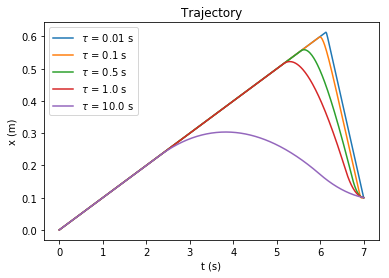

In [11]:
def acceleration(v,tf):
    acc = []
    dt = tf/len(v)
    for i in range(1,len(v)):
        acc.append((v[i]-v[i-1])/dt)
    return(acc)

# PARAMETERS FOR THE COMPUTATION
vtapis = 0.1
kxpenalty=100  # steepness of penalty cost (the higher the steeper: 100 very steep, 3 slightly, 1 very diffused)
x0 = 0.0     # initial position
xf = 0.1     # final position 
tf = 7.     # final time (duration of experiment)
sigma = 1.708

tau_acc = []
tau = [0.01,0.1,0.5,1.0,10.0]

for toto in tau:
    xk,xdotk,tk,acck,tak = optimal_trajectory(tau_res=toto,sigma=sigma,x0=x0,xf=xf,tf=tf,vtapis=vtapis,kxpenalty=kxpenalty)
    acceleration_profile=acceleration(np.asarray(xdotk),tf)
    max_acc = np.min(acceleration_profile)
    tau_acc.append(max_acc)
    plt.plot(tk,xk,label=r'$\tau$ = '+str(toto)+' s')

plt.legend()
plt.ylabel('x (m)')
plt.xlabel('t (s)')
plt.title('Trajectory')
plt.savefig('tau_keller.pdf')

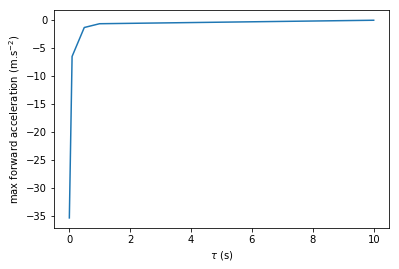

In [10]:
plt.plot(tau,tau_acc)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel('max forward acceleration (m.s$^{-2})$')

plt.savefig('tau_keller_acc.pdf')